kaggle : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

In [48]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import random
import cv2
from PIL import Image 
import matplotlib.pyplot as plt

[1342, 3875, 234, 390, 8, 8]


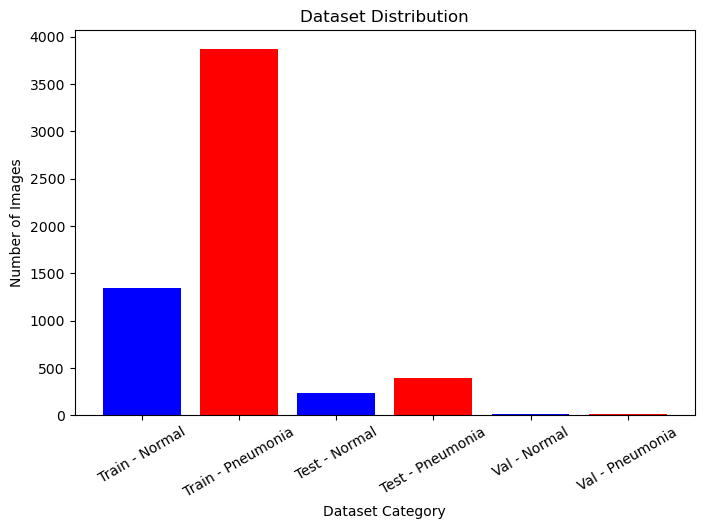

In [2]:
train_normal_dir  = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/train/NORMAL'
train_pneumonia_dir = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/train/PNEUMONIA'

test_normal_dir  = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/test/NORMAL'
test_pneumonia_dir = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/test/PNEUMONIA'

val_normal_dir  = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/val/NORMAL'
val_pneumonia_dir = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/val/PNEUMONIA'

train_normal_count = len(os.listdir(train_normal_dir))
train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
test_normal_count = len(os.listdir(test_normal_dir))
test_pneumonia_count = len(os.listdir(test_pneumonia_dir))
val_normal_count = len(os.listdir(val_normal_dir))
val_pneumonia_count = len(os.listdir(val_pneumonia_dir))

categories = ["Train - Normal", "Train - Pneumonia", "Test - Normal", "Test - Pneumonia", "Val - Normal", "Val - Pneumonia"]
counts = [train_normal_count , train_pneumonia_count , test_normal_count, test_pneumonia_count, val_normal_count, val_pneumonia_count]
print(counts)

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=["blue", "red", "blue", "red"])
plt.xlabel("Dataset Category")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.xticks(rotation=30) 
plt.show()

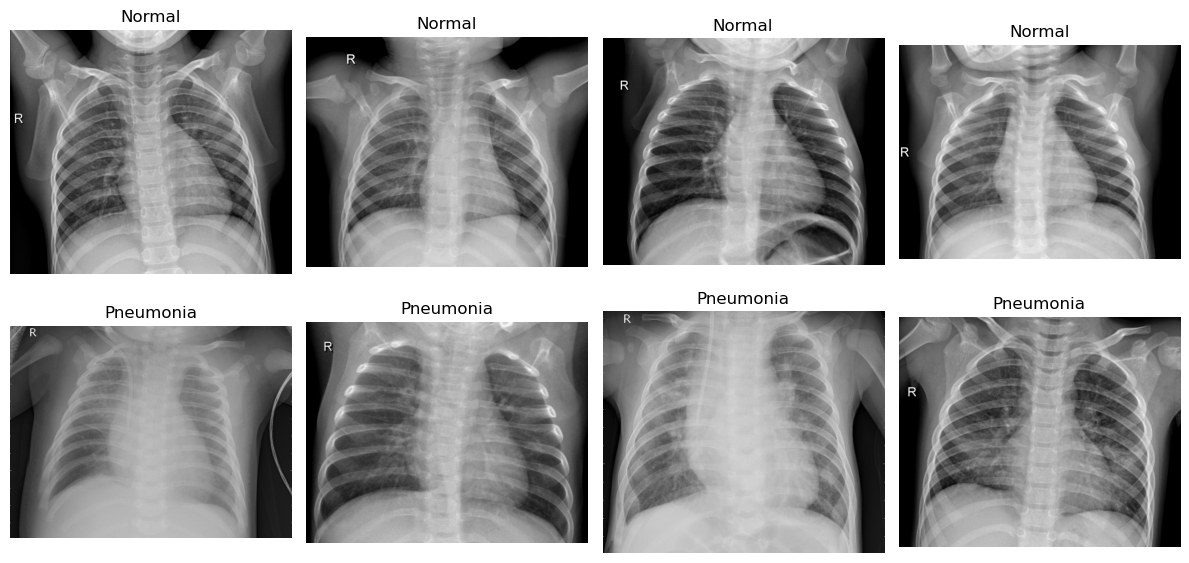

In [3]:
normal_images = random.sample(os.listdir(train_normal_dir), 4)
pneumonia_images = random.sample(os.listdir(train_pneumonia_dir), 4)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, img_name in enumerate(normal_images):
    img = cv2.imread(os.path.join(train_normal_dir, img_name))
    axes[0, i].imshow(img)
    axes[0, i].set_title("Normal")
    axes[0, i].axis("off")

for i, img_name in enumerate(pneumonia_images):
    img = cv2.imread(os.path.join(train_pneumonia_dir, img_name))
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [4]:
val_dir = '/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/val'

IMG_SIZE = (224, 224)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, IMG_SIZE)   
    img = img / 255.0  

    return img

val_images = []
val_labels = []


for label in ["NORMAL", "PNEUMONIA"]:
    label_dir = os.path.join(val_dir, label)
    
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        processed_img = preprocess_image(img_path)
        val_images.append(processed_img)
        val_labels.append(0 if label == "NORMAL" else 1)  

val_images = np.array(val_images)
val_labels = np.array(val_labels)

print("val images shape:", val_images.shape)
print("val labels shape:", val_labels.shape)

val images shape: (16, 224, 224, 3)
val labels shape: (16,)


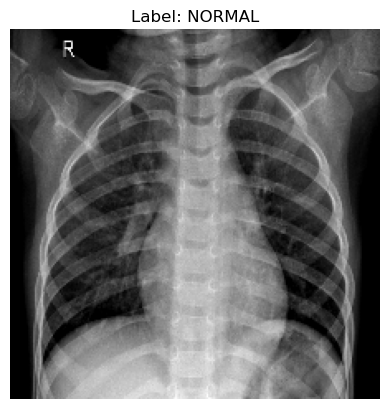

In [5]:
plt.imshow(val_images[0]) 
plt.title(f"Label: {'NORMAL' if val_labels[0] == 0 else 'PNEUMONIA'}")
plt.axis('off') 
plt.show()

Found 5217 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


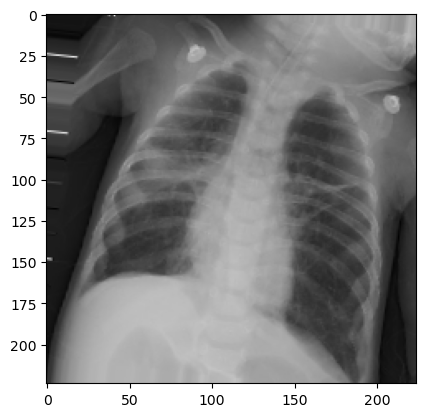

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold


train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=30,  
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory='/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)






K = 5 
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)



val_generator = val_datagen.flow_from_directory(
    directory='/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

augmented_img = train_generator.next()[0][0]
plt.imshow(augmented_img)
plt.show()

In [7]:
pip install tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy  import Adam


base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, activation="relu"),  
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(512, activation="relu"),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation="relu"), 
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation="relu"),  
    layers.BatchNormalization(),
    layers.Dropout(0.2),  
    
    layers.Dense(1, activation="sigmoid")
])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_15 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)              

In [22]:
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau

optimizer = Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)


for layer in base_model.layers[80:]:
    layer.trainable = True

history = model.fit(
    train_generator,
    epochs=20, 
    validation_data=val_generator,
    callbacks=[early_stopping , lr_reduction]
)

Epoch 1/20
164/164 [==============================] - 126s 730ms/step - loss: 0.6038 - accuracy: 0.6920 - val_loss: 1.6161 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 2/20
164/164 [==============================] - 119s 725ms/step - loss: 0.4096 - accuracy: 0.8361 - val_loss: 0.9735 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 3/20
164/164 [==============================] - 122s 741ms/step - loss: 0.3096 - accuracy: 0.8959 - val_loss: 0.9006 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 4/20
164/164 [==============================] - 121s 738ms/step - loss: 0.2236 - accuracy: 0.9316 - val_loss: 1.3478 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 5/20
164/164 [==============================] - 121s 738ms/step - loss: 0.1862 - accuracy: 0.9454 - val_loss: 1.2930 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 6/20
164/164 [==============================] - 121s 735ms/step - loss: 0.1664 - accuracy: 0.9557 - val_loss: 1.1559 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 7/20
164/164 [==

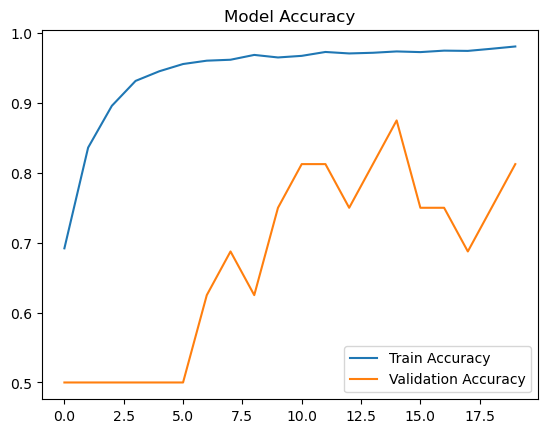

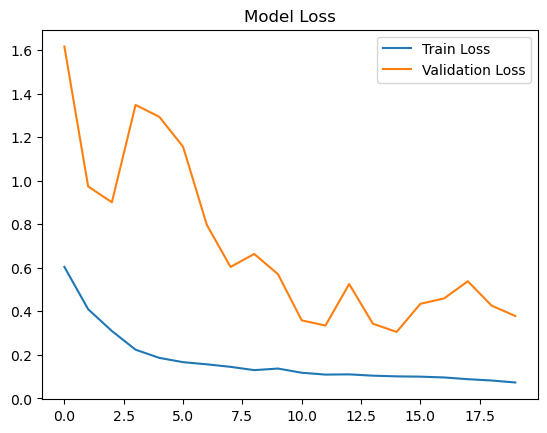

In [25]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)  # 只做 rescale，不做增強

test_generator = test_datagen.flow_from_directory(
    directory='/Users/z88756212/Documents/AI/python/chest_xray/chest_xray/test',  
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary", 
    shuffle=False  
)

Found 624 images belonging to 2 classes.


In [35]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 [==============================] - 5s 193ms/step - loss: 0.2515 - accuracy: 0.9022
Test Loss: 0.2515
Test Accuracy: 90.22%


In [41]:
y_pred_probs = model.predict(test_generator)

y_pred = (y_pred_probs > 0.5).astype(int)

y_true = test_generator.classes 

20/20 [==============================] - 5s 202ms/step


In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86       234
   Pneumonia       0.88      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



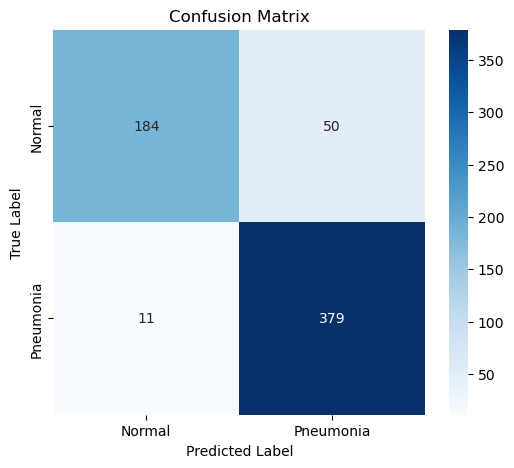

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
